In [2]:
pip show tensorflow

Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: tf_keras
Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import mse
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

# TensorFlow 로그 메시지 숨기기
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [73]:
# 데이터 로드 및 전처리
agg_5min = pd.read_csv('aggregation_10min_cpu.csv')

# 데이터 스케일링 (Min-Max 스케일링)
scaler = MinMaxScaler()
agg_5min['CPU rate'] = scaler.fit_transform(agg_5min['CPU rate'].values.reshape(-1, 1))

# 슬라이딩 윈도우 설정
window_size = 24  # 윈도우 크기 (조정 가능)
step_size = 5    # 윈도우 이동 간격 (조정 가능)

# 슬라이딩 윈도우를 사용하여 데이터 생성
def create_sliding_window_data(data, lookback_time=24, predict_time=5):
    X = []
    y = []

    for i in range(0, len(data) - (lookback_time - 1) - predict_time,5):
        x_window = data['CPU rate'].iloc[i:i+lookback_time].values
        y_value = data['CPU rate'].iloc[i+lookback_time:i+lookback_time+predict_time]

        X.append(x_window)
        y.append(y_value)

    return np.array(X), np.array(y)

x, t = create_sliding_window_data(agg_5min)

# 데이터 분할 (학습 및 테스트 데이터)
x_train, x_temp, t_train, t_temp = train_test_split(x, t, test_size=0.2, shuffle=False)

In [74]:
# LSTM 모델 생성
cell_size = 128
timesteps = 24
feature = 1

model = Sequential(name="CPU_LSTM")
model.add(LSTM(cell_size, input_shape=(timesteps, feature), return_sequences=True))
model.add(LSTM(cell_size))
model.add(Dense(5))

model.compile(loss=mse, optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
model.summary()

Model: "CPU_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 24, 128)           66560     
                                                                 
 lstm_35 (LSTM)              (None, 128)               131584    
                                                                 
 dense_17 (Dense)            (None, 5)                 645       
                                                                 
Total params: 198789 (776.52 KB)
Trainable params: 198789 (776.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
# 모델 학습
x_val, x_test, t_val, t_test = train_test_split(x_temp, t_temp, test_size=0.5, shuffle=False)  # val: 10%, test: 10%

# 모델 학습
history = model.fit(
    x_train,
    t_train,
    epochs=20,
    batch_size=8,
    validation_data=(x_val, t_val),  # 검증 데이터
    verbose=1
)

Epoch 1/20
83/83 [==============================] - 4s 32ms/step - loss: 0.0516 - root_mean_squared_error: 0.2272 - mean_absolute_error: 0.1657 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1115 - val_mean_absolute_error: 0.0795
Epoch 2/20
83/83 [==============================] - 2s 25ms/step - loss: 0.0053 - root_mean_squared_error: 0.0731 - mean_absolute_error: 0.0558 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1132 - val_mean_absolute_error: 0.0766
Epoch 3/20
83/83 [==============================] - 2s 25ms/step - loss: 0.0055 - root_mean_squared_error: 0.0738 - mean_absolute_error: 0.0551 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145 - val_mean_absolute_error: 0.0859
Epoch 4/20
83/83 [==============================] - 2s 25ms/step - loss: 0.0054 - root_mean_squared_error: 0.0734 - mean_absolute_error: 0.0545 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118 - val_mean_absolute_error: 0.0776
Epoch 5/20
83/83 [==============================] - 2s 25ms/

3/3 [==============================] - 1s 10ms/step
Test Loss (MSE): 0.0059137968346476555
Test RMSE: 0.07690121978521347
Test MAE: 0.060389623045921326
Test MAPE: 8.900489384513357


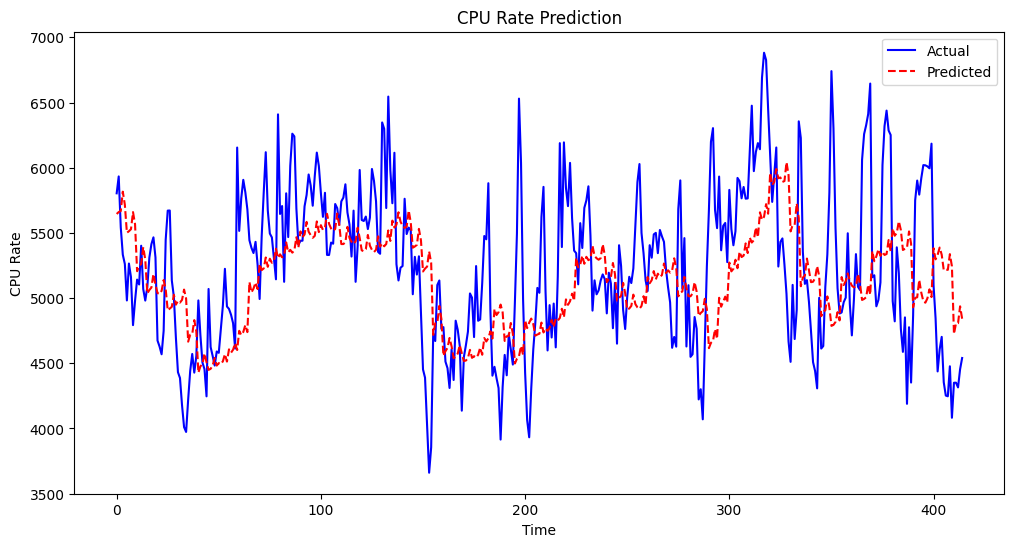

In [76]:
# 모델 평가
loss, rmse, mae = model.evaluate(x_test, t_test, verbose=1)
y_pred = model.predict(x_test)
t_test_reset = scaler.inverse_transform(t_test.reshape(-1, 1))  # t_test를 2D 배열로 변환
y_pred_reset = scaler.inverse_transform(y_pred.reshape(-1, 1))  # y_pred는 이미 2D 배열이므로 추가 변환이 필요 없음

mape = np.mean(np.abs((t_test_reset - y_pred_reset) / t_test_reset)) * 100

print('Test Loss (MSE):', loss)
print('Test RMSE:', rmse)

print('Test MAE:', mae)
print('Test MAPE:', mape)


# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(t_test_reset, label='Actual', color='blue')
plt.plot(y_pred_reset, label='Predicted', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('CPU Rate')
plt.title('CPU Rate Prediction')
plt.legend()
plt.show()

In [6]:
# 데이터 로드 및 전처리
agg_10min = pd.read_csv('aggregation_10min_cpu.csv')

# 데이터 스케일링 (Min-Max 스케일링)
scaler = MinMaxScaler()
agg_10min['CPU rate'] = scaler.fit_transform(agg_10min['CPU rate'].values.reshape(-1, 1))

# 슬라이딩 윈도우 설정
window_size = 24  # 윈도우 크기 (조정 가능)
step_size = 1     # 윈도우 이동 간격 (조정 가능)

# 슬라이딩 윈도우를 사용하여 데이터 생성
def create_sliding_window_data(data, lookback_time=24, predict_time=3):
    X = []
    y = []

    for i in range(0,len(data) - (lookback_time - 1) - predict_time,3):
        x_window = data['CPU rate'].iloc[i:i+lookback_time].values
        y_value = data['CPU rate'].iloc[i+lookback_time:i+lookback_time+predict_time]

        X.append(x_window)
        y.append(y_value)

    return np.array(X), np.array(y)

x_10min, t_10min = create_sliding_window_data(agg_10min)

print(len(x_10min), len(t_10min))

# 데이터 분할 (학습 및 테스트 데이터)
x_train, x_test, t_train, t_test = train_test_split(x_10min, t_10min, test_size=0.2, shuffle=False)

1384 1384


In [12]:
# aggregation_10min LSTM 모델 생성
cell_size = 128
timesteps = 24
feature = 1

model = Sequential(name="CPU_LSTM")
model.add(LSTM(cell_size, input_shape=(timesteps, feature), return_sequences=True))
model.add(LSTM(cell_size))
model.add(Dense(3))

model.compile(loss=mse, optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
model.summary()

Model: "CPU_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 128)           66560     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 198531 (775.51 KB)
Trainable params: 198531 (775.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.13.0
GPU available: []


In [14]:
# 모델 학습
history = model.fit(x_train, t_train, epochs=50, batch_size=32, validation_data=(x_test, t_test), verbose=1)

Epoch 1/50
35/35 [==============================] - 4s 49ms/step - loss: 0.1034 - root_mean_squared_error: 0.3215 - mean_absolute_error: 0.2801 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173 - val_mean_absolute_error: 0.0926
Epoch 2/50
35/35 [==============================] - 1s 33ms/step - loss: 0.0070 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0639 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996 - val_mean_absolute_error: 0.0779
Epoch 3/50
35/35 [==============================] - 1s 33ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725 - mean_absolute_error: 0.0548 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0957 - val_mean_absolute_error: 0.0736
Epoch 4/50
35/35 [==============================] - 1s 33ms/step - loss: 0.0051 - root_mean_squared_error: 0.0717 - mean_absolute_error: 0.0538 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0947 - val_mean_absolute_error: 0.0717
Epoch 5/50
35/35 [==============================] - 1s 33ms/

9/9 [==============================] - 0s 11ms/step
Test Loss (MSE): 0.007291048299521208
Test RMSE: 0.08538763225078583
Test MAE: 0.06206650286912918
Test MAPE: 8.06747587447568


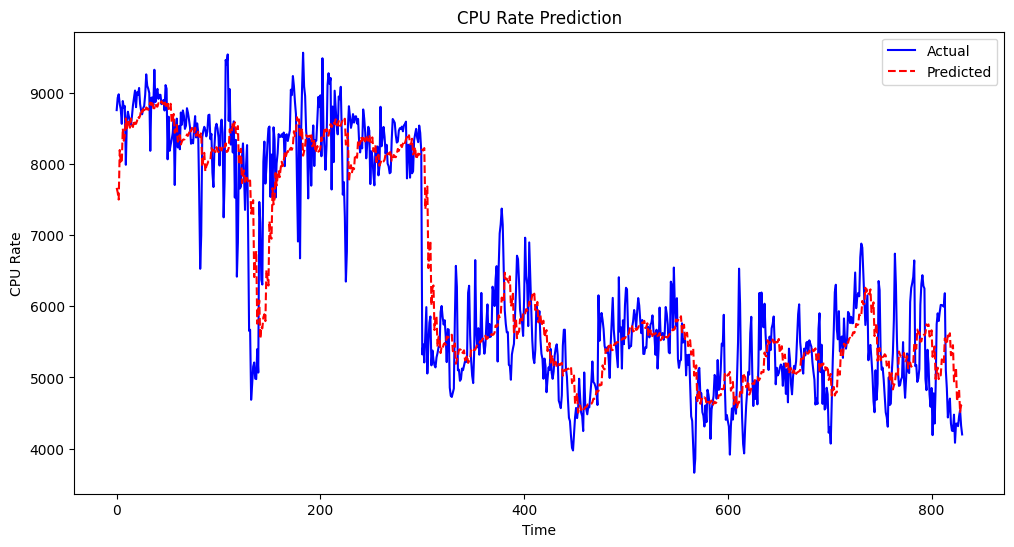

In [17]:
# 모델 평가
loss, rmse, mae = model.evaluate(x_test, t_test, verbose=1)
y_pred = model.predict(x_test)
t_test_reset = scaler.inverse_transform(t_test.reshape(-1, 1))  # t_test를 2D 배열로 변환
y_pred_reset = scaler.inverse_transform(y_pred.reshape(-1,1))  # y_pred는 이미 2D 배열이므로 추가 변환이 필요 없음

mape = np.mean(np.abs((t_test_reset - y_pred_reset) / t_test_reset)) * 100

print('Test Loss (MSE):', loss)
print('Test RMSE:', rmse)
print('Test MAE:', mae)
print('Test MAPE:', mape)


# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(t_test_reset, label='Actual', color='blue')
plt.plot(y_pred_reset, label='Predicted', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('CPU Rate')
plt.title('CPU Rate Prediction')
plt.legend()
plt.show()

In [28]:
# 데이터 로드 및 전처리
agg_5min = pd.read_csv('aggregation_5min_cpu.csv')

# 데이터 스케일링 (Min-Max 스케일링)
scaler = MinMaxScaler()
agg_5min['CPU rate'] = scaler.fit_transform(agg_5min['CPU rate'].values.reshape(-1, 1))

# 슬라이딩 윈도우 설정
window_size = 24  # 윈도우 크기 (조정 가능)
step_size = 10     # 윈도우 이동 간격 (조정 가능)

# 슬라이딩 윈도우를 사용하여 데이터 생성
def create_sliding_window_data(data, lookback_time=24, predict_time=10):
    X = []
    y = []

    for i in range(0,len(data) - (lookback_time - 1) - predict_time,10):
        x_window = data['CPU rate'].iloc[i:i+lookback_time].values
        y_value = data['CPU rate'].iloc[i+lookback_time:i+lookback_time+predict_time]

        X.append(x_window)
        y.append(y_value)

    return np.array(X), np.array(y)

x_5min, t_5min = create_sliding_window_data(agg_5min)

print(len(x_5min), len(t_5min))

# 데이터 분할 (학습 및 테스트 데이터)
x_train, x_test, t_train, t_test = train_test_split(x_5min, t_5min, test_size=0.2, shuffle=False)

832 832


In [29]:
# aggregation_10min LSTM 모델 생성
cell_size = 128
timesteps = 24
feature = 1

model = Sequential(name="CPU_LSTM")
model.add(LSTM(cell_size, input_shape=(timesteps, feature), return_sequences=True))
model.add(LSTM(cell_size))
model.add(Dense(10))

model.compile(loss=mse, optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
model.summary()

Model: "CPU_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 24, 128)           66560     
                                                                 
 lstm_9 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 199434 (779.04 KB)
Trainable params: 199434 (779.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.13.0
GPU available: []


In [31]:
# 모델 학습
history = model.fit(x_train, t_train, epochs=50, batch_size=32, validation_data=(x_test, t_test), verbose=1)

Epoch 1/50
21/21 [==============================] - 3s 56ms/step - loss: 0.1586 - root_mean_squared_error: 0.3982 - mean_absolute_error: 0.3708 - val_loss: 0.2009 - val_root_mean_squared_error: 0.4482 - val_mean_absolute_error: 0.4098
Epoch 2/50
21/21 [==============================] - 1s 34ms/step - loss: 0.0623 - root_mean_squared_error: 0.2496 - mean_absolute_error: 0.2093 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1654 - val_mean_absolute_error: 0.1327
Epoch 3/50
21/21 [==============================] - 1s 34ms/step - loss: 0.0095 - root_mean_squared_error: 0.0976 - mean_absolute_error: 0.0735 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1075 - val_mean_absolute_error: 0.0843
Epoch 4/50
21/21 [==============================] - 1s 37ms/step - loss: 0.0051 - root_mean_squared_error: 0.0716 - mean_absolute_error: 0.0535 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0966 - val_mean_absolute_error: 0.0740
Epoch 5/50
21/21 [==============================] - 1s 25ms/

6/6 [==============================] - 0s 10ms/step
Test Loss (MSE): 0.008444514125585556
Test RMSE: 0.09189403802156448
Test MAE: 0.06754571199417114
Test MAPE: 8.599949254652866


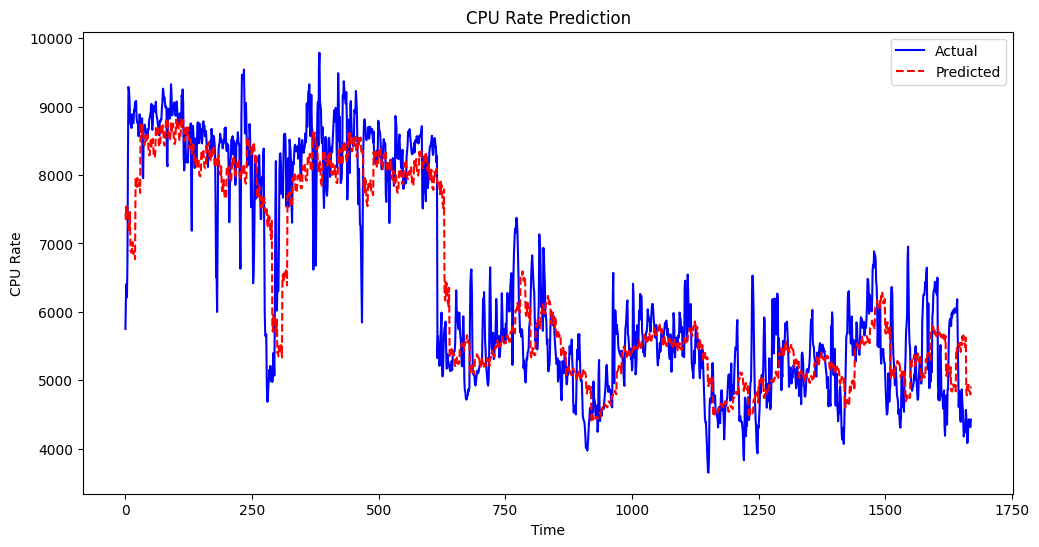

In [33]:
# 모델 평가
loss, rmse, mae = model.evaluate(x_test, t_test, verbose=1)
y_pred = model.predict(x_test)
t_test_reset = scaler.inverse_transform(t_test.reshape(-1, 1))  # t_test를 2D 배열로 변환
y_pred_reset = scaler.inverse_transform(y_pred.reshape(-1,1))  # y_pred는 이미 2D 배열이므로 추가 변환이 필요 없음

mape = np.mean(np.abs((t_test_reset - y_pred_reset) / t_test_reset)) * 100

print('Test Loss (MSE):', loss)
print('Test RMSE:', rmse)
print('Test MAE:', mae)
print('Test MAPE:', mape)


# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(t_test_reset, label='Actual', color='blue')
plt.plot(y_pred_reset, label='Predicted', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('CPU Rate')
plt.title('CPU Rate Prediction')
plt.legend()
plt.show()